# CarND-Vehicle-Detection Project
---

The following steps are omplemented in following Cells:

* Build features from images such as color histogram/spatial bins and HOG which are useful in predicting cars in a given image
* Train a SVM classifier with labeled car and noncar images based on features extracted
* Detect vehicles in a image/video stream based on sliding window technique using trained model as predictor.
* Use of heat map technique and previous frame data to remove false positives


## Import packages

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:

def convert_color(img,color_space='BGR'):
    '''
    this functions takes in a BGR Image and converts it to specified color space
    
    '''
    # Convert image to new color space (if specified,else return image as is)
    #Assumes input image is BGR format
    if color_space !='BGR':
        if color_space=='RGB':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if color_space=='HSV':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        elif color_space=='YUV':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
        elif color_space=='LAB':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2Lab)
        elif color_space=='HLS':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
        elif color_space=='YCrCb':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
        elif color_space=='LUV':
            feature_image=cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
    else: 
        feature_image = np.copy(img)
    return feature_image

## Read in training dataset and report the car vs notcar image count

In [3]:
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

print("Number of car images:",len(cars))
print("Number of noncar images:",len(notcars))

Number of car images: 8792
Number of noncar images: 8968


### Plot few car/not car images

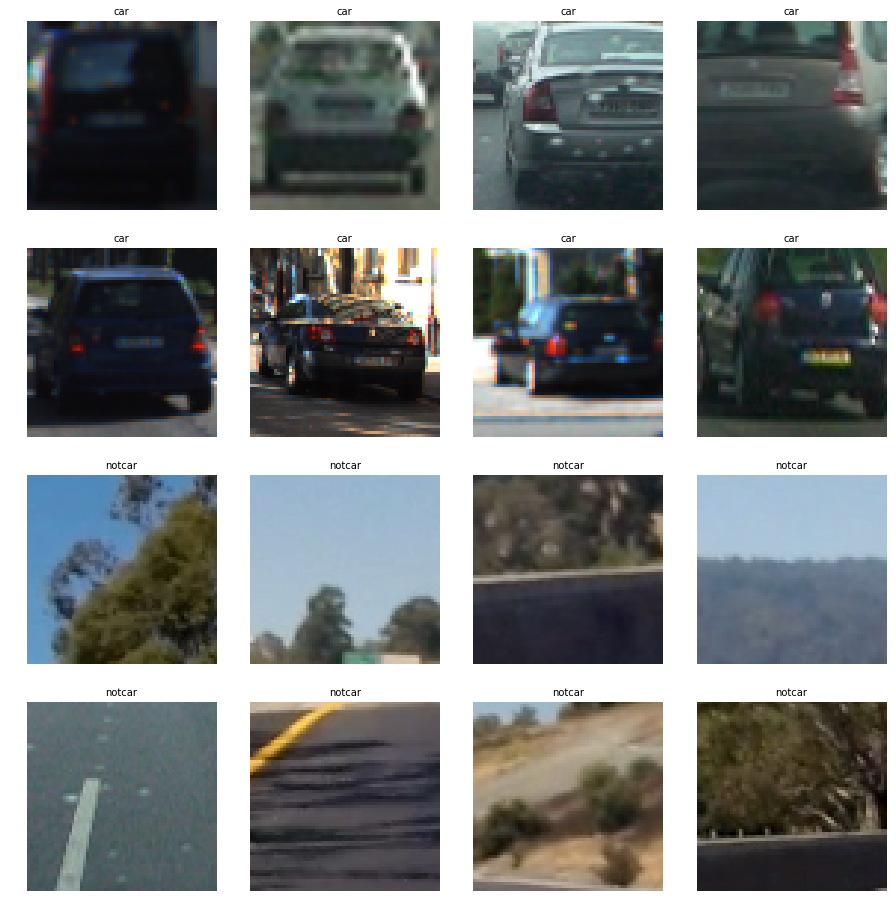

In [4]:
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Plot car and not car images
for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=convert_color(img,color_space='RGB')
    
    
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=convert_color(img,color_space='RGB')
    axs[i].axis('off')
    axs[i].set_title('notcar', fontsize=10)
    axs[i].imshow(img)

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

(32,) (96,)


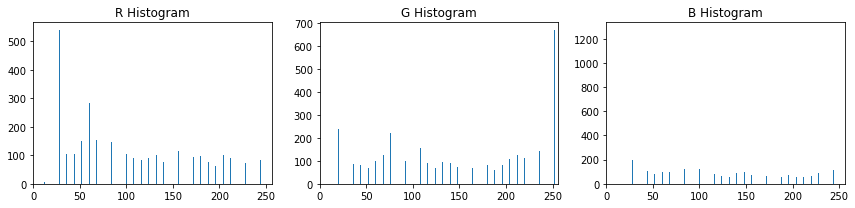

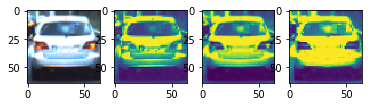

In [6]:
img = cv2.imread('./cutouts/cutouts/white_car_for_color_hist.png')
img=convert_color(img,color_space='RGB')
br=(0,256)
#img = img.astype(np.float32)/255
#br=(0.,1.)
rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=32, bins_range=(br[0], br[1]))
print(rh[0].shape,feature_vec.shape)
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(br[0],br[1])
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(br[0],br[1])
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(br[0],br[1])
    plt.title('B Histogram')
    fig.tight_layout()

    #print("Rch:",np.sum(rh[0]),"Gch:",np.sum(gh[0]),"Bch:",np.sum(bh[0]))
    f,ax=plt.subplots(1,4)
    ax[0].imshow(img)
    ax[1].imshow(img[:,:,0])
    ax[2].imshow(img[:,:,1])
    ax[3].imshow(img[:,:,2])
else:
    print('Your function is returning None for at least one variable...')



In [7]:
#img = cv2.imread('./cutouts/cutouts/white_car_for_color_hist.png')
#hsv=convert_color(img,color_space='HSV')
#br=(0,256)
#rh, gh, bh, bincen, feature_vec = color_hist(hsv, nbins=32, bins_range=(br[0], br[1]))
#
#if rh is not None:
#    fig = plt.figure(figsize=(12,3))
#    plt.subplot(131)
#    plt.bar(bincen, rh[0])
#    plt.xlim(br[0],br[1])
#    plt.title('H Histogram')
#    plt.subplot(132)
#    plt.bar(bincen, gh[0])
#    plt.xlim(br[0],br[1])
#    plt.title('S Histogram')
#    plt.subplot(133)
#    plt.bar(bincen, bh[0])
#    plt.xlim(br[0],br[1])
#    plt.title('V Histogram')
#    fig.tight_layout()
#    print("Hch:",np.sum(rh[0]),"Sch:",np.sum(gh[0]),"Vch:",np.sum(bh[0]))
#    f,ax=plt.subplots(1,4)
#    ax[0].imshow(img)
#    ax[1].imshow(hsv[:,:,0])
#    ax[2].imshow(hsv[:,:,1])
#    ax[3].imshow(hsv[:,:,2])
#else:
#    print('Your function is returning None for at least one variable...')

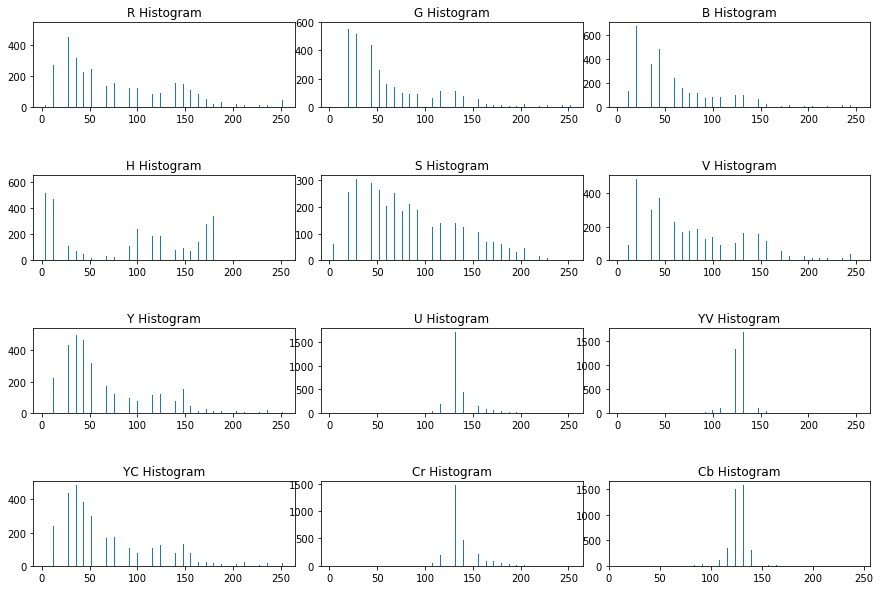

In [8]:
#img = cv2.imread('./cutouts/cutouts/white_car_for_color_hist.png')
img = cv2.imread('./cutouts/cutouts/red_car_for_color_hist.png')

rgb=convert_color(img,color_space='RGB')
br=(0,256)
rh, gh, bh, rgbbincen, rgb_feature_vec = color_hist(rgb, nbins=32, bins_range=(br[0], br[1]))

hsv=convert_color(img,color_space='HSV')
br=(0,256)
hh, sh, vh, hsvbincen, hsv_feature_vec = color_hist(hsv, nbins=32, bins_range=(br[0], br[1]))

yuv=convert_color(img,color_space='YUV')
br=(0,256)
yh, uh, yvh, yuvbincen, yuv_feature_vec = color_hist(yuv, nbins=32, bins_range=(br[0], br[1]))

ycrcb=convert_color(img,color_space='YCrCb')
br=(0,256)
ych, crh, cbh, ycrcbbincen, ycrcb_feature_vec = color_hist(ycrcb, nbins=32, bins_range=(br[0], br[1]))

fp,axp=plt.subplots(4,3,figsize=(15,10))
fp.subplots_adjust(hspace =.8, wspace=.1)
axp=axp.ravel()

axp[0].bar(rgbbincen,rh[0])
plt.xlim(br[0],br[1])
axp[0].set_title('R Histogram')
axp[1].bar(rgbbincen,gh[0])
plt.xlim(br[0],br[1])
axp[1].set_title('G Histogram')
axp[2].bar(rgbbincen,bh[0])
plt.xlim(br[0],br[1])
axp[2].set_title('B Histogram')

axp[3].bar(hsvbincen,hh[0])
plt.xlim(br[0],br[1])
axp[3].set_title('H Histogram')
axp[4].bar(hsvbincen,sh[0])
plt.xlim(br[0],br[1])
axp[4].set_title('S Histogram')
axp[5].bar(hsvbincen,vh[0])
plt.xlim(br[0],br[1])
axp[5].set_title('V Histogram')

axp[6].bar(yuvbincen,yh[0])
plt.xlim(br[0],br[1])
axp[6].set_title('Y Histogram')
axp[7].bar(yuvbincen,uh[0])
plt.xlim(br[0],br[1])
axp[7].set_title('U Histogram')
axp[8].bar(yuvbincen,yvh[0])
plt.xlim(br[0],br[1])
axp[8].set_title('YV Histogram')

axp[9].bar(ycrcbbincen,ych[0])
plt.xlim(br[0],br[1])
axp[9].set_title('YC Histogram')
axp[10].bar(ycrcbbincen,crh[0])
plt.xlim(br[0],br[1])
axp[10].set_title('Cr Histogram')
axp[11].bar(ycrcbbincen,cbh[0])
plt.xlim(br[0],br[1])
axp[11].set_title('Cb Histogram')

fig.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

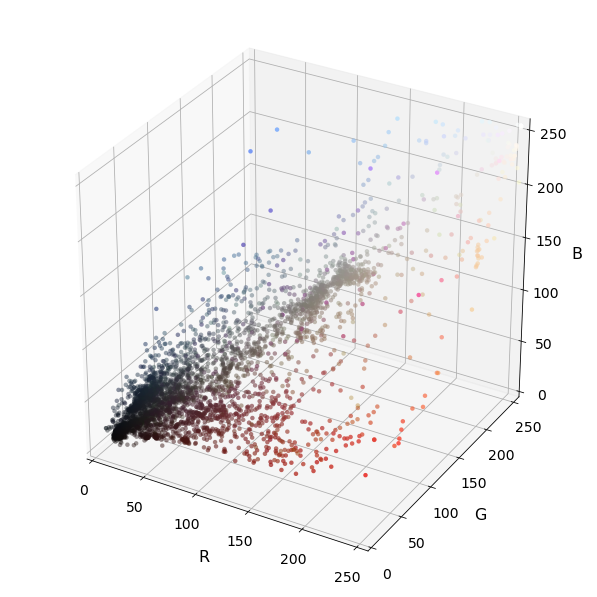

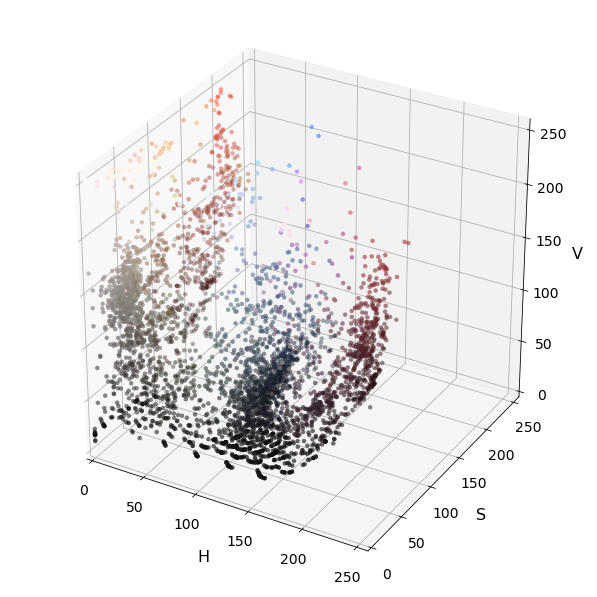

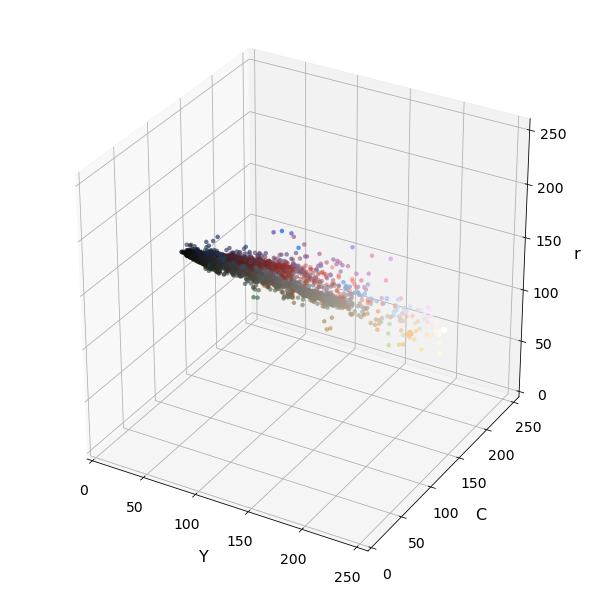

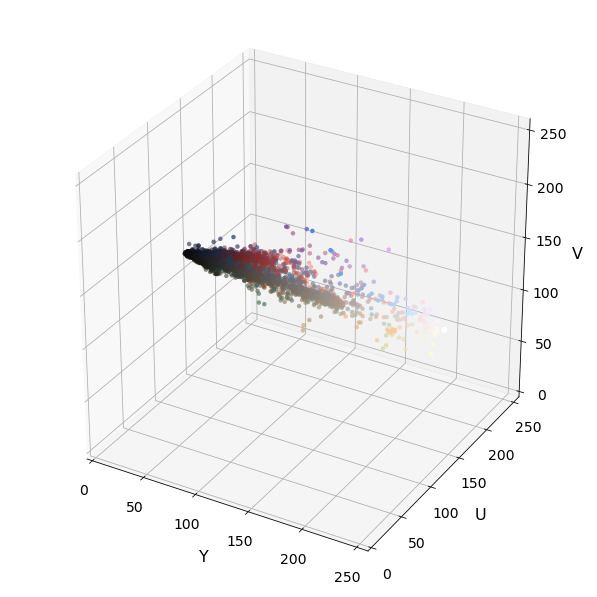

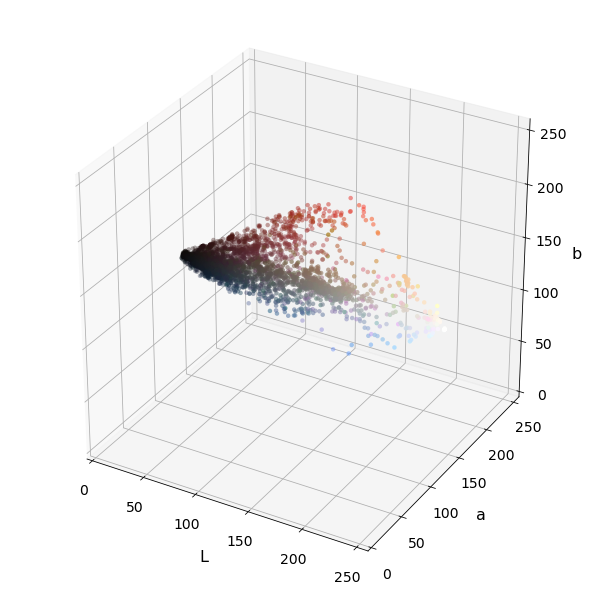

In [10]:
#Look at different color spaces
img = cv2.imread('./cutouts/cutouts/red_car_for_color_hist.png')
# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
#img_small=bin_spatial(img,size=(np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)))
#print(img_small.shape)
                      
# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_Lab = cv2.cvtColor(img_small, cv2.COLOR_BGR2Lab)
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.show()

plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
plt.show()

plot3d(img_small_Lab, img_small_rgb, axis_labels=list("Lab"))
plt.show()

In [11]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size,interpolation=cv2.INTER_NEAREST).ravel() 
    # Return the feature vector
    return features

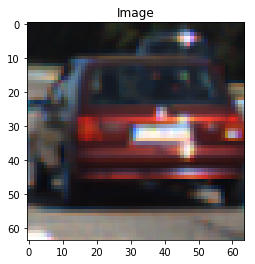

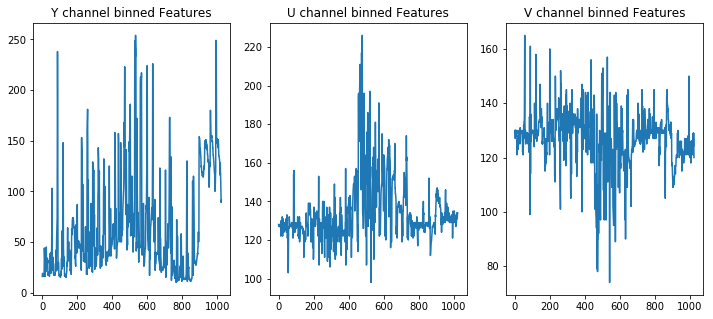

In [12]:
img = cv2.imread('./cutouts/cutouts/red_car_for_color_hist.png')

rgb=convert_color(img,color_space='RGB')

#hsv=convert_color(img,color_space='HSV')

yuv=convert_color(img,color_space='YUV')

ycrcb=convert_color(img,color_space='YCrCb')



feature_vec_y = bin_spatial(ycrcb[:,:,0],size=(32, 32))
feature_vec_u = bin_spatial(ycrcb[:,:,1],size=(32, 32))
feature_vec_v = bin_spatial(ycrcb[:,:,2],size=(32, 32))

# Plot features
plt.imshow(rgb)
plt.title('Image')
fsp,axsp=plt.subplots(1,3,figsize=(12,5))
axsp[0].plot(feature_vec_y)
axsp[0].set_title('Y channel binned Features')
axsp[1].plot(feature_vec_u)
axsp[1].set_title('U channel binned Features')
axsp[2].plot(feature_vec_v)
axsp[2].set_title('V channel binned Features')


In [13]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True,transform_sqrt=False):
    '''
    This function generates HOG features for a single channel image
    orient: number of bins of directions  for feature
    pix_per_cell : pixels considered in a cell to generate direction gradient(it is used a 2x2 tuple of same size)
    cells_per_block : number of cells in row and column to normalize hog feature on(it is used a 2x2 tuple of same size)
    vis: flag to generate hog image output
    feature_vec : flag to extract feature vector
    '''
    
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, block_norm='L2-Hys',
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, block_norm='L2-Hys',
                       visualise=vis, feature_vector=feature_vec)
        return features

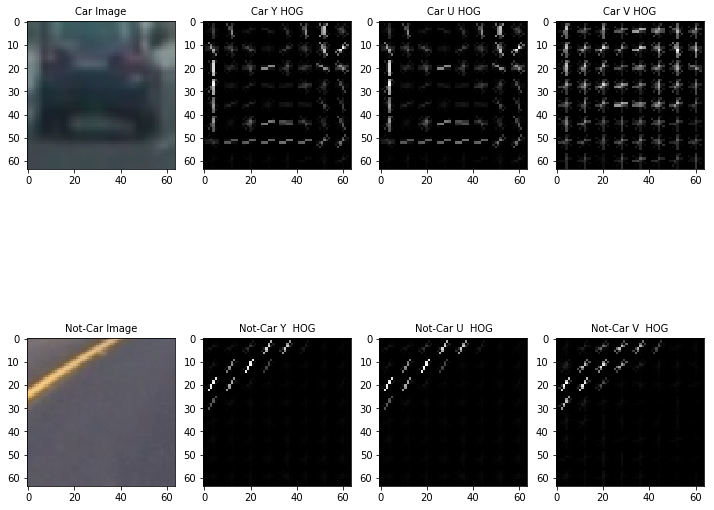

In [14]:

#cimg = cv2.imread(cars[2])
cimg = cv2.imread(cars[15])
crgb=convert_color(cimg,color_space='RGB')
cyuv=convert_color(cimg,color_space='YUV')

notcimg = cv2.imread(notcars[15])
notcrgb=convert_color(notcimg,color_space='RGB')
notcyuv=convert_color(notcimg,color_space='YUV')


orient=9
pix_per_cell=8
cells_per_block=2

fcar_y, car_hog_y = get_hog_features(cyuv[:,:,0], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)
fnotcar_y, notcar_hog_y = get_hog_features(notcyuv[:,:,0], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)

fcar_u, car_hog_u = get_hog_features(cyuv[:,:,0], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)
fnotcar_u, notcar_hog_u = get_hog_features(notcyuv[:,:,0], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)

fcar_v, car_hog_v = get_hog_features(cyuv[:,:,2], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)
fnotcar_v, notcar_hog_v = get_hog_features(notcyuv[:,:,2], orient, pix_per_cell, cells_per_block, vis=True, feature_vec=True)

# Visualize 
fh, axh = plt.subplots(2, 4, figsize=(10,10))
fh.subplots_adjust(hspace =.2, wspace=.1)
axh=axh.ravel()
axh[0].imshow(crgb)
axh[0].set_title('Car Image', fontsize=10)
axh[1].imshow(car_hog_y, cmap='gray')
axh[1].set_title('Car Y HOG', fontsize=10)
axh[2].imshow(car_hog_u, cmap='gray')
axh[2].set_title('Car U HOG', fontsize=10)
axh[3].imshow(car_hog_v, cmap='gray')
axh[3].set_title('Car V HOG', fontsize=10)


axh[4].imshow(notcrgb)
axh[4].set_title('Not-Car Image', fontsize=10)
axh[5].imshow(notcar_hog_y, cmap='gray')
axh[5].set_title('Not-Car Y  HOG', fontsize=10)
axh[6].imshow(notcar_hog_u, cmap='gray')
axh[6].set_title('Not-Car U  HOG', fontsize=10)
axh[7].imshow(notcar_hog_v, cmap='gray')
axh[7].set_title('Not-Car V  HOG', fontsize=10)

fh.tight_layout(pad=1.0, w_pad=0.5, h_pad=2.0)

In [15]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    ctr=0
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        ######################################
        #image = mpimg.imread(file)
        #cimg = cv2.imread(file)
        #image=convert_color(cimg,color_space='RGB')
        # apply color conversion if other than 'RGB'
        #if color_space != 'RGB':
        #    if color_space == 'HSV':
        #        feature_image =convert_color(cimg,color_space='HSV')
        #    #elif color_space == 'LUV':
        #    #    feature_image =convert_color(cimg,color_space='LUV')
        #    #elif color_space == 'HLS':
        #    #    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        #    elif color_space == 'YUV':
        #        feature_image =convert_color(cimg,color_space='YUV')
        #    elif color_space == 'YCrCb':
        #        feature_image =convert_color(cimg,color_space='YCrCb')
        #else: feature_image = np.copy(image) 
        #############################################
        
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
     

        if spatial_feat == True:
            spatial_features = bin_spatial((feature_image*255).astype(np.uint8), size=spatial_size)
            file_features.append(spatial_features)
            if ctr==0:
                axt[0].plot(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rh,gh,bh,bincen,hist_features = color_hist((feature_image*255).astype(np.uint8), nbins=hist_bins)
            if ctr==0:
                axt[1].bar(bincen,rh[0])
            ctr +=1
            #rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=32, bins_range=(br[0], br[1]))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



89.84 Seconds to extract features...
shape of feature array (17760, 4356)
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356


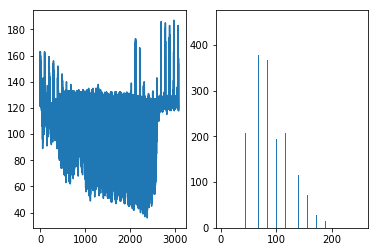

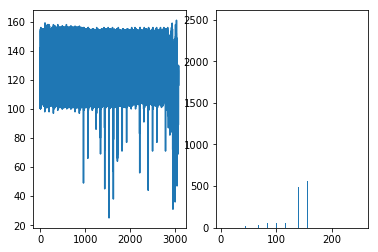

In [16]:
# Feature extraction parameters
#color_space='HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#color_space = 'YUV' 
color_space='YCrCb'

orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_size = (32, 32) # Spatial binning dimensions
#spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


#checking effect of mpimg on color and spatial hist
ft,axt=plt.subplots(1,2)

t = time.time()

car_features = extract_features(cars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
#plt.show()

ft,axt=plt.subplots(1,2)
notcar_features = extract_features(notcars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
print('shape of feature array',X.shape)

 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

In [17]:
# Use a linear SVC 
svc = LinearSVC()
#svc params to search for
parameters = {'kernel':('linear', 'rbf'), 'C':[.5,1,5]}
            
#svr = SVC()
#clf = GridSearchCV(svr, parameters)

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
#clf.fit(X_train, y_train)
#print("best fit options are:",clf.best_params_)
#best fit options are: {'C': 5, 'kernel': 'rbf'}
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



pickle_fname='colorspace_'+color_space+'_spatialbin_'+str(spatial_feat)+'_colhist_'+str(hist_feat)+'.p'

for_pickle={'svc':svc,'scaler':X_scaler,'orient':orient,'pix_per_cell':pix_per_cell,
                        'cell_per_block':cell_per_block,'spatial_size':spatial_size,
                        'hist_bins':hist_bins,'spatial_feat':spatial_feat,'hist_feat':hist_feat,'hog_feat':hog_feat,'hog_channel':hog_channel,'color_space':color_space}

            
            
            
print("Pickle file being written:",pickle_fname)
pickle.dump( for_pickle, open( pickle_fname, 'wb' ) )

14.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.029 Seconds to predict 10 labels with SVC
Pickle file being written: colorspace_YCrCb_spatialbin_True_colhist_True.p


In [35]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,
              spatial_feat=True,hist_feat=True
              ):
    
    # detected bounding boxes
    bbox = []
    
    ctrfc=0
    #keep a copy of orig image for color_histogram
    img_orig=np.copy(img)
    
    #scale
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    #ctrans_tosearch=convert_color(img_tosearch,color_space=cspace)
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)),cv2.INTER_CUBIC)
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  
    nyblocks = (ch1.shape[0] // pix_per_cell)+1   
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    #nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            #print("HoG features shape",hog_features.shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            if spatial_feat:
                # Extract the image patch
                subimg = cv2.resize((ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]*255).astype(np.uint8), spatial_size,cv2.INTER_CUBIC)
                spatial_features = bin_spatial(subimg, size=spatial_size)
                if ctrfc==0 and show_scalar:
                    axfc[0].plot(spatial_features)
            if hist_feat:
                # Get color features
                #subimg_unnorm=(subimg*255).astype(np.uint8)
                #hist_features = color_hist(subimg_unnorm, nbins=hist_bins)
                rh,gh,bh,bincen,hist_features = color_hist(subimg, nbins=hist_bins)
                #rh,gh,bh,bincen,hist_features = color_hist((feature_image*255).astype(np.uint8), nbins=hist_bins)
                if ctrfc==0 and show_scalar:
                    axfc[1].bar(bincen,rh[0])
            ctrfc +=1
            # Scale features and make a prediction
            #assumed hog is always enabled, so if spatial and hist are enabled concatenate and scale
            if spatial_feat and hist_feat:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
                test_prediction = svc.predict(test_features)
            if not spatial_feat and not hist_feat:
                test_features = X_scaler.transform(hog_features).reshape(1, -1)
                test_prediction = svc.predict(test_features)
                #test_prediction = svc.predict(hog_features)
                
            if  (not spatial_feat and hist_feat) or ( spatial_feat and not hist_feat):
                print("either only spatial or hist feature is enabled for feature extraction from frame")
                print("Unexpected, check your setting")
                exit()

            
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox

img shape (720, 1280, 3)
spatial enabled: True Hist enabled: True
2 bboxes found in image


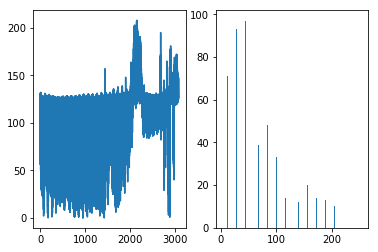

In [19]:
show_scalar=True
#test_img_bgr = cv2.imread('./test_images/test1.jpg')
#
#test_img = convert_color(test_img_bgr,color_space='RGB')
ffc,axfc=plt.subplots(1,2)
test_img = mpimg.imread('./test_images/test1.jpg')
print("img shape",test_img.shape)
ystart = 400
ystop = 656
scale = 1.5
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
print("spatial enabled:",spatial_feat,"Hist enabled:",hist_feat)
bbox = find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, 
                 X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat,hist_feat)


print(len(bbox), 'bboxes found in image')

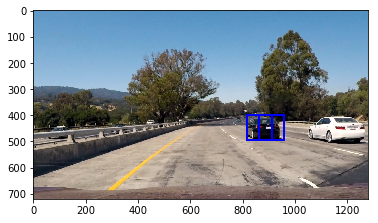

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

show_scalar=False
im_bbox=draw_boxes(test_img, bbox, color=(0, 0, 255), thick=6)
plt.imshow(im_bbox)

11 bboxes found in image


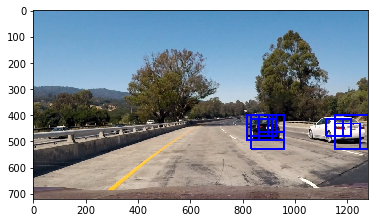

In [21]:
#Multiscale slide window
#order ystart,ystop,scale
param_list=((400,464,1.0),(416,480,1.0),(400,496,1.5),(432,528,1.5),(400,528,2.0),(432,560,2.0),(400,596,3.5),(464,660,3.5))
bbox=[]
for j in   param_list:
    ystart=j[0]
    ystop=j[1]
    scale=j[2]
    bbox_l = find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, svc, 
                 X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat,hist_feat)
    bbox.extend(bbox_l)
print(len(bbox), 'bboxes found in image')

im_bbox=draw_boxes(test_img, bbox, color=(0, 0, 255), thick=6)
plt.imshow(im_bbox)

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print('box is',box)
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

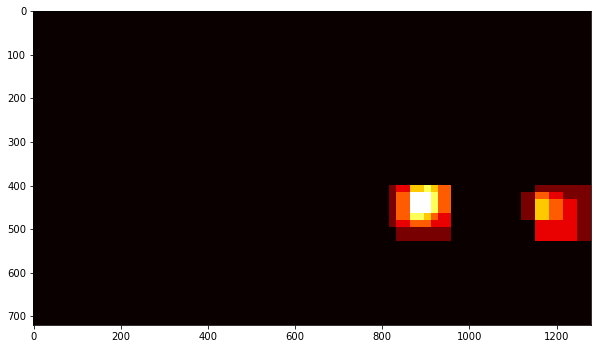

In [23]:
heat = np.zeros_like(test_img[:,:,0])
heat = add_heat(heat, bbox)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


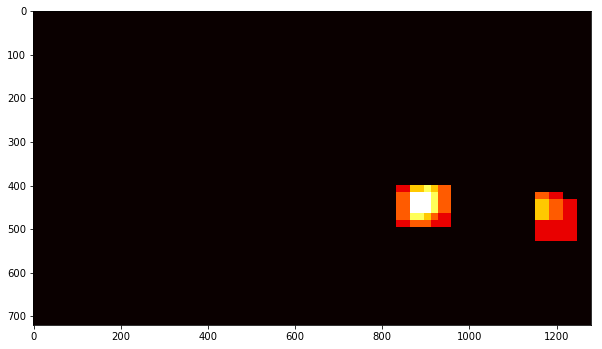

In [25]:
heat = apply_threshold(heat, 1)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')

In [26]:
nz=heat.nonzero()
nzx=nz[0]
nzy=nz[1]
print(len(nzx))
print("---------")
print(len(nzy))

22528
---------
22528


In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
    # Return the image
    return img

2 cars found


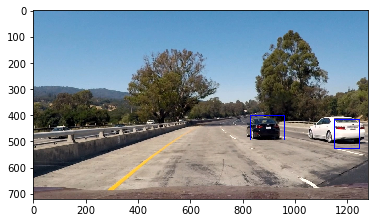

In [28]:
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
print(labels[1], 'cars found')
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
plt.imshow(draw_img)

In [29]:
#pipeline_no smoothing
param_list=((400,464,1.0),(416,480,1.0),(400,496,1.5),(432,528,1.5),
  (400,528,2.0),(432,560,2.0),(400,596,3.5),(464,660,3.5))

#param_list = [(400, 600, 1.2), (400, 470, 1.0), (420, 480, 1.0), 
#                  (400, 500, 1.5), (430, 530, 1.5), (400, 530, 2.0),
#                  (470, 660, 3.0)]

def pipeline_nosmoothing(img):
        
    
    
    bbox=[]
    for j in   param_list:
        ystart=j[0]
        ystop=j[1]
        scale=j[2]
        bbox_l = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, 
                 X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat,hist_feat)
        bbox.extend(bbox_l)
    print(len(bbox), 'bboxes found in image')
    #######################################
    heat = np.zeros_like(img[:,:,0])
    heat = add_heat(heat, bbox)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    ########################################
    
    labels = label(heatmap)
    print(labels[1], 'cars found')
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    

idx: 0 imname: ./test_images\test1.jpg
11 bboxes found in image
2 cars found
idx: 1 imname: ./test_images\test2.jpg
1 bboxes found in image
0 cars found
idx: 2 imname: ./test_images\test3.jpg
2 bboxes found in image
1 cars found
idx: 3 imname: ./test_images\test4.jpg
16 bboxes found in image
2 cars found
idx: 4 imname: ./test_images\test5.jpg
12 bboxes found in image
2 cars found
idx: 5 imname: ./test_images\test6.jpg
14 bboxes found in image
2 cars found


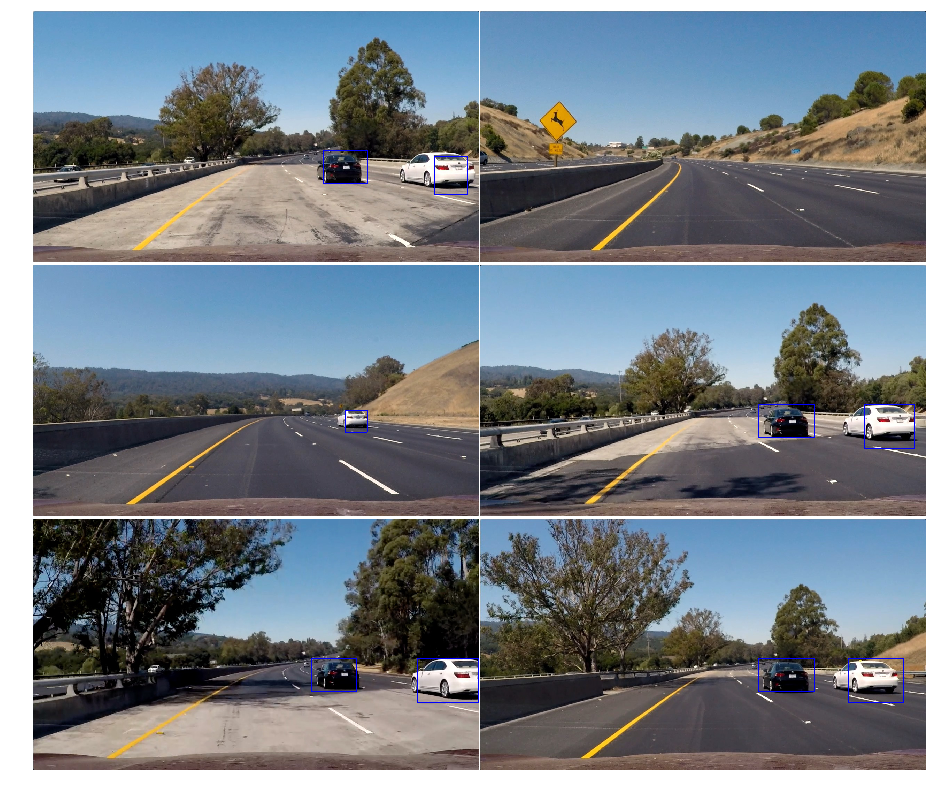

In [30]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    print("idx:",i,"imname:",im)
    axs[i].imshow(pipeline_nosmoothing(mpimg.imread(im)))
    axs[i].axis('off')

In [31]:
  
# Define a class to store data from video
class Frame_Detect():
    def __init__(self):
        # history of bbox for previous n frames
        self.prev_bbox = []
        self.n_frames=20
        self.nr_cars=[]
        
        
    def add_bbox(self, box):
        self.prev_bbox.append(box)
        if len(self.prev_bbox) > self.n_frames:
            # remove older frame data than self.n_frames
            self.prev_bbox = self.prev_bbox[len(self.prev_bbox)-self.n_frames:]
    def add_bbox_cars(self,box,cars):
        self.prev_bbox.append(box)
        self.nr_cars.appned(cars)
        if len(self.nr_cars) > self.n_frames:
            # remove older frame data than self.n_frames
            self.prev_bbox = self.prev_bbox[len(self.prev_bbox)-self.n_frames:]
            self.nr_cars = self.nr_cars[len(self.nr_cars)-self.n_frames:]
    #check prev 10 frames for finding avg nr of cars, 
    #combined with using only heatmap areas with top nr_cars area
    #will delay the detection for 10 frames but will remove false positives
    def calc_cars(self,nr_cars):
        if nr_cars != (sum(self.nr_cars[:-10])/10):
            return int((sum(self.nr_cars[:-10])/10))
        else:
            return nr_cars
            
        

In [32]:


def pipeline(img):
        
    
    
    bbox=[]
    for j in   param_list:
        ystart=j[0]
        ystop=j[1]
        scale=j[2]
        bbox_l = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, 
                 X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat,hist_feat)
        bbox.extend(bbox_l)
    #print(len(bbox), 'bboxes found in image')
    
    if len(bbox) > 0:
        frames_track.add_bbox(bbox)
    #######################################
    heat = np.zeros_like(img[:,:,0])
    #heat = add_heat(heat, bbox)
    #heat = apply_threshold(heat, 1)
    for box in frames_track.prev_bbox:
        heat = add_heat(heat, box)
    
    #divide the heatmap image by number of frames it been tracked for
    heat=heat//(frames_track.n_frames)
    #heat=heat//len(frames_track.prev_bbox)
    heat = apply_threshold(heat, 1)
    
    
    heatmap = np.clip(heat, 0, 255)
    ########################################
    
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    #######################################
    #prepare heatmap to be added to main image
    #resize heatmap
    hmcopy=np.copy(heatmap)
    heat_to_add=cv2.resize(hmcopy,(320,192),cv2.INTER_CUBIC)
    #resize image
    resized_img = cv2.resize(img,(320,192),cv2.INTER_CUBIC)
    resized_gray = cv2.cvtColor(resized_img , cv2.COLOR_RGB2GRAY)
    res_R=np.copy(resized_gray)
    res_R[(heat_to_add>0)] =255
    res_G =np.copy(resized_gray)
    res_G[(heat_to_add>0)] =0
    res_B =np.copy(resized_gray)
    res_B[(heat_to_add>0)] =0
    
    draw_img[0:192,0:320,0]=res_R     #np.clip(res_R,0,255)
    draw_img[0:192,0:320,1]=resized_gray
    draw_img[0:192,0:320,2]=resized_gray
    
    
    

    return draw_img
    
    

In [33]:
show_scalar=False
frames_track=None
frames_track = Frame_Detect()
param_list=((400,464,1.0),(416,480,1.0),(400, 600, 1.2),(400,496,1.5),(432,528,1.5),
  (400,528,2.0),(432,560,2.0),(400,596,3.5),(464,660,3.5))
#param_list = [(400, 600, 1.2), (400, 470, 1.0), (420, 480, 1.0), 
#                  (400, 500, 1.5), (430, 530, 1.5), (400, 530, 2.0),
#                  (470, 660, 3.0)]



vidout = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(vidout, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:30<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 31.9 s


In [36]:
show_scalar=False
frames_track=None
frames_track = Frame_Detect()
#param_list=((400,464,1.0),(416,480,1.0),(400, 600, 1.2),(400,496,1.5),(432,528,1.5),
#  (400,528,2.0),(432,560,2.0),(400,596,3.5),(464,660,3.5))
param_list = [(400, 600, 1.2), (400, 470, 1.0), (420, 480, 1.0), 
                  (400, 500, 1.5), (430, 530, 1.5), (400, 530, 2.0),
                  (470, 660, 3.0)]
vidout_proj = 'project_video_out.mp4'
#clip_proj = VideoFileClip('project_video.mp4').subclip(4,8)
#clip_proj = VideoFileClip('project_video.mp4').subclip(8,12)
#clip_proj = VideoFileClip('project_video.mp4').subclip(12,16)
#clip_proj = VideoFileClip('project_video.mp4').subclip(16,20)
#clip_proj = VideoFileClip('project_video.mp4').subclip(20,24)
#clip_proj = VideoFileClip('project_video.mp4').subclip(24,28)
#clip_proj = VideoFileClip('project_video.mp4').subclip(28,32)
clip_proj = VideoFileClip('project_video.mp4')

clip_proj_out = clip_proj.fl_image(pipeline)
%time clip_proj_out.write_videofile(vidout_proj, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [21:12<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 21min 16s
